# Energy Time Series Forecasting

## Introduction

Prédiction de la consommation d’énergie du business groupe dans Alesund à partir des données historiques.

## Import des bibliothèques

In [79]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import seaborn as sns

## Chargement des données 

In [80]:
df_alesund_data = pd.read_csv("meteo_consump_alesund_data.csv")  
df_alesund_data.head()

,Consumption_group_Ålesund,VOLUME_KWH,METERINGPOINT_COUNT,Date,wind_speed,t2m_C,surface_pressure
0,private,57961.562,27060,2021-01-01 00:00:00,2.798005,1.68923,98874.56
1,industry,13558.855,1029,2021-01-01 00:00:00,2.798005,1.68923,98874.56
2,business,30582.870,3784,2021-01-01 00:00:00,2.798005,1.68923,98874.56
3,private,56258.645,27060,2021-01-01 01:00:00,2.630726,1.32168,98905.06
4,industry,13649.810,1029,2021-01-01 01:00:00,2.630726,1.32168,98905.06


## Filtrage des données de business groupe 

In [81]:
# Filtrer pour ne garder que les lignes où la colonne est égale à "business"
df_business_consumption= df_alesund_data[df_alesund_data['Consumption_group_Ålesund'] == 'business']

# Supprimer la colonne après le filtrage
df_business_consumption = df_business_consumption.drop(columns=['Consumption_group_Ålesund'])
df_business_consumption=df_business_consumption.reset_index(drop=True)
df_business_consumption.head()

,VOLUME_KWH,METERINGPOINT_COUNT,Date,wind_speed,t2m_C,surface_pressure
0,30582.870,3784,2021-01-01 00:00:00,2.798005,1.68923,98874.560
1,30352.254,3784,2021-01-01 01:00:00,2.630726,1.32168,98905.060
2,30774.594,3784,2021-01-01 02:00:00,2.387332,1.01553,98930.625
3,30846.584,3784,2021-01-01 03:00:00,1.984651,0.77847,98928.000
4,31745.682,3784,2021-01-01 04:00:00,1.515596,0.66543,98949.560


In [82]:
df_business_consumption['Date'] = pd.to_datetime(
    df_business_consumption['Date'])

In [83]:
# Création de la nouvelle colonne
df_business_consumption["Consommation"] = df_business_consumption["VOLUME_KWH"] / df_business_consumption["METERINGPOINT_COUNT"]

# Suppression des deux colonnes d'origine
df_business_consumption.drop(columns=["VOLUME_KWH", "METERINGPOINT_COUNT"], inplace=True)


## Feature engineering

In [84]:

# Extraire les composants de date
df_business_consumption['hour'] = df_business_consumption['Date'].dt.hour
df_business_consumption['month'] = df_business_consumption['Date'].dt.month
df_business_consumption['weekday'] = df_business_consumption['Date'].dt.weekday  # 0 = lundi, 6 = dimanche
df_business_consumption['dayofyear'] = df_business_consumption['Date'].dt.dayofyear

# Vérification
df_business_consumption.head()


,Date,wind_speed,t2m_C,surface_pressure,Consommation,hour,month,weekday,dayofyear
0,2021-01-01 00:00:00,2.798005,1.68923,98874.560,8.082154,0,1,4,1
1,2021-01-01 01:00:00,2.630726,1.32168,98905.060,8.021209,1,1,4,1
2,2021-01-01 02:00:00,2.387332,1.01553,98930.625,8.132821,2,1,4,1
3,2021-01-01 03:00:00,1.984651,0.77847,98928.000,8.151846,3,1,4,1
4,2021-01-01 04:00:00,1.515596,0.66543,98949.560,8.389451,4,1,4,1


##  Prétraitement des données

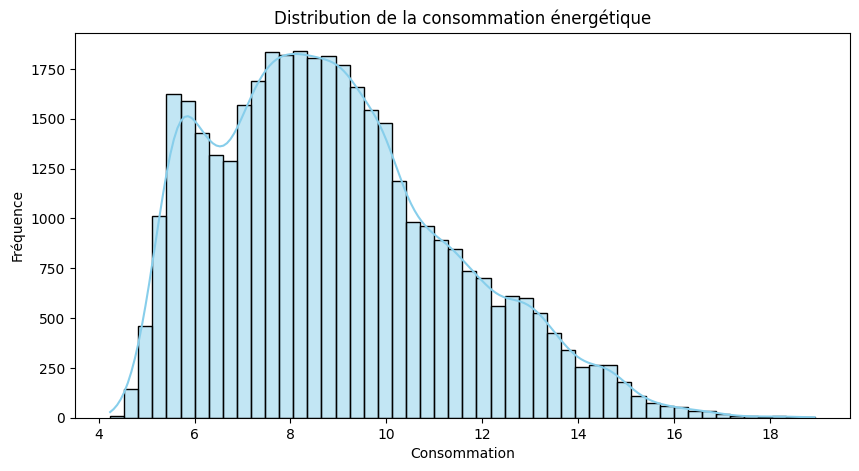

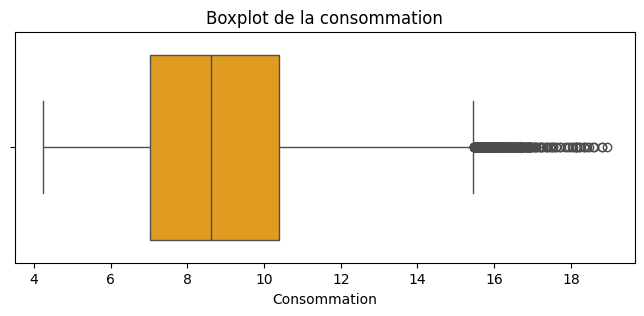

In [85]:

# Histogramme
plt.figure(figsize=(10, 5))
sns.histplot(df_business_consumption["Consommation"], bins=50, kde=True, color="skyblue")
plt.title("Distribution de la consommation énergétique")
plt.xlabel("Consommation")
plt.ylabel("Fréquence")
plt.show()

# Boxplot (pour voir les outliers)
plt.figure(figsize=(8, 3))
sns.boxplot(x=df_business_consumption["Consommation"], color="orange")
plt.title("Boxplot de la consommation")
plt.show()


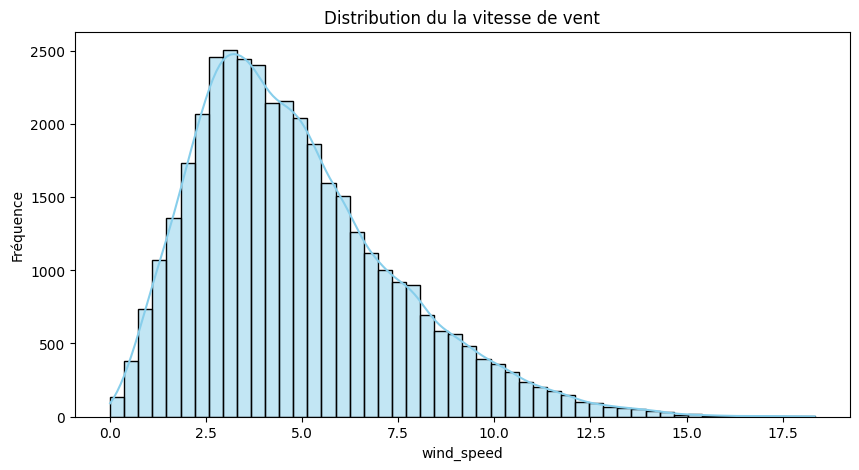

In [86]:
# Histogramme
plt.figure(figsize=(10, 5))
sns.histplot(df_business_consumption["wind_speed"], bins=50, kde=True, color="skyblue")
plt.title("Distribution du la vitesse de vent")
plt.xlabel("wind_speed")
plt.ylabel("Fréquence")
plt.show()


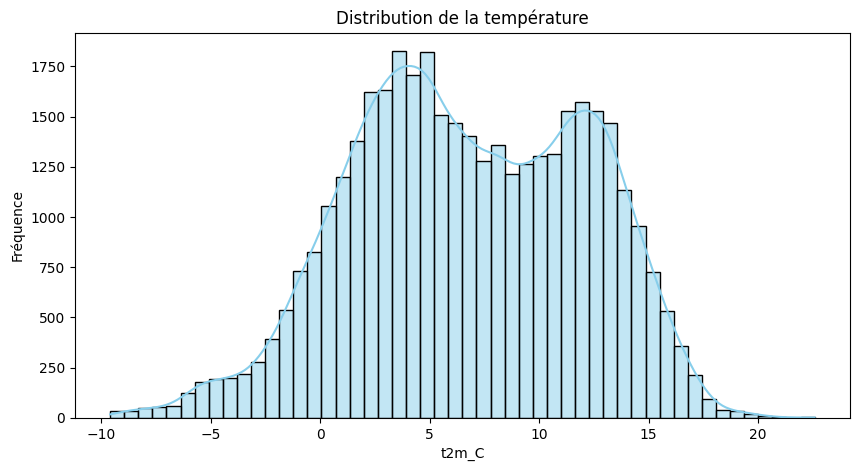

In [87]:
# Histogramme
plt.figure(figsize=(10, 5))
sns.histplot(df_business_consumption["t2m_C"], bins=50, kde=True, color="skyblue")
plt.title("Distribution de la température")
plt.xlabel("t2m_C")
plt.ylabel("Fréquence")
plt.show()

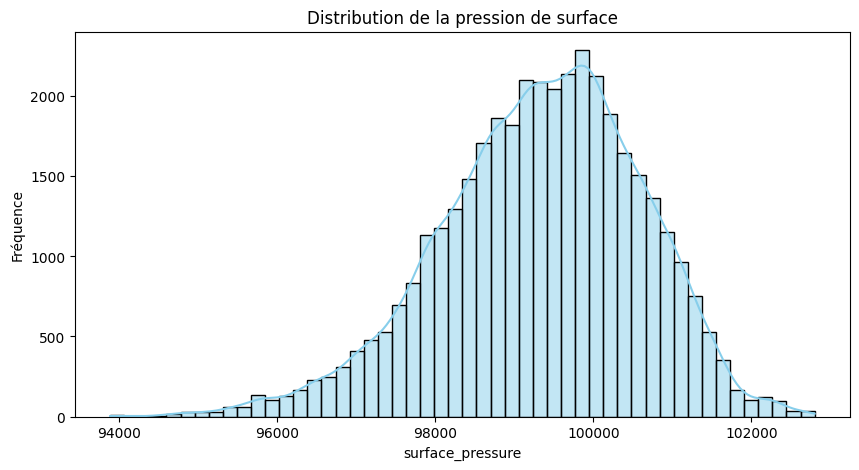

In [88]:
# Histogramme
plt.figure(figsize=(10, 5))
sns.histplot(df_business_consumption["surface_pressure"], bins=50, kde=True, color="skyblue")
plt.title("Distribution de la pression de surface")
plt.xlabel("surface_pressure")
plt.ylabel("Fréquence")
plt.show()

MinMaxScaler  il est plus adapté aux données asymétriques et bornées.

In [89]:
from sklearn.preprocessing import MinMaxScaler

# Liste des colonnes à normaliser
colonnes_a_normaliser = ["Consommation" , "t2m_C"]

# Dictionnaire pour stocker les scalers (utile pour faire inverse_transform plus tard)
scalers = {}

# Copie du DataFrame pour ne pas modifier l'original
df_normalise = df_business_consumption.copy()

# Boucle sur chaque colonne à normaliser
for col in colonnes_a_normaliser:
    scaler = MinMaxScaler()
    df_normalise[col] = scaler.fit_transform(df_normalise[[col]])
    scalers[col] = scaler  # on garde le scaler si besoin d'inverser plus tard


StandardScaler pour la distribution normale

In [90]:
# Colonnes à scaler avec StandardScaler
colonnes_standard = ["surface_pressure", "wind_speed"]

# Dictionnaire pour stocker les scalers
scalers = {}

# StandardScaler
for col in colonnes_standard:
    scaler = StandardScaler()
    df_normalise[col] = scaler.fit_transform(df_normalise[[col]])
    scalers[col] = scaler


In [91]:
# Encodage cyclique
df_normalise["hour_sin"] = np.sin(2 * np.pi * df_normalise["hour"] / 24)
df_normalise["hour_cos"] = np.cos(2 * np.pi * df_normalise["hour"] / 24)

df_normalise["month_sin"] = np.sin(2 * np.pi * df_normalise["month"] / 12)
df_normalise["month_cos"] = np.cos(2 * np.pi * df_normalise["month"] / 12)

df_normalise["weekday_sin"] = np.sin(2 * np.pi * df_normalise["weekday"] / 7)
df_normalise["weekday_cos"] = np.cos(2 * np.pi * df_normalise["weekday"] / 7)

df_normalise["dayofyear_sin"] = np.sin(2 * np.pi * df_normalise["dayofyear"] / 365)
df_normalise["dayofyear_cos"] = np.cos(2 * np.pi * df_normalise["dayofyear"] / 365)

In [92]:
df_normalise

,Date,wind_speed,t2m_C,surface_pressure,Consommation,hour,month,weekday,dayofyear,hour_sin,hour_cos,month_sin,month_cos,weekday_sin,weekday_cos,dayofyear_sin,dayofyear_cos
0,2021-01-01 00:00:00,-0.775388,0.350590,-0.356407,0.261538,0,1,4,1,0.000000e+00,1.000000,0.5,0.866025,-0.433884,-0.900969,0.017213,0.999852
1,2021-01-01 01:00:00,-0.839012,0.339167,-0.332534,0.257389,1,1,4,1,2.588190e-01,0.965926,0.5,0.866025,-0.433884,-0.900969,0.017213,0.999852
2,2021-01-01 02:00:00,-0.931585,0.329652,-0.312523,0.264986,2,1,4,1,5.000000e-01,0.866025,0.5,0.866025,-0.433884,-0.900969,0.017213,0.999852
3,2021-01-01 03:00:00,-1.084743,0.322284,-0.314578,0.266281,3,1,4,1,7.071068e-01,0.707107,0.5,0.866025,-0.433884,-0.900969,0.017213,0.999852
4,2021-01-01 04:00:00,-1.263145,0.318771,-0.297702,0.282455,4,1,4,1,8.660254e-01,0.500000,0.5,0.866025,-0.433884,-0.900969,0.017213,0.999852
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38457,2025-05-22 09:00:00,0.843048,0.508829,0.384255,0.560058,9,5,3,142,7.071068e-01,-0.707107,0.5,-0.866025,0.433884,-0.900969,0.642055,-0.766659
38458,2025-05-22 10:00:00,0.519997,0.506474,0.390666,0.550630,10,5,3,142,5.000000e-01,-0.866025,0.5,-0.866025,0.433884,-0.900969,0.642055,-0.766659
38459,2025-05-22 11:00:00,0.695210,0.517676,0.405585,0.543712,11,5,3,142,2.588190e-01,-0.965926,0.5,-0.866025,0.433884,-0.900969,0.642055,-0.766659
38460,2025-05-22 12:00:00,0.859432,0.524023,0.414782,0.522251,12,5,3,142,1.224647e-16,-1.000000,0.5,-0.866025,0.433884,-0.900969,0.642055,-0.766659


In [93]:
df_normalise.index=df_normalise['Date']

df_normalise.drop(columns=["Date","hour", "month", "weekday", "dayofyear"], inplace=True)

df_normalise.head()

,wind_speed,t2m_C,surface_pressure,Consommation,hour_sin,hour_cos,month_sin,month_cos,weekday_sin,weekday_cos,dayofyear_sin,dayofyear_cos
Date,,,,,,,,,,,,
2021-01-01 00:00:00,-0.775388,0.350590,-0.356407,0.261538,0.000000,1.000000,0.5,0.866025,-0.433884,-0.900969,0.017213,0.999852
2021-01-01 01:00:00,-0.839012,0.339167,-0.332534,0.257389,0.258819,0.965926,0.5,0.866025,-0.433884,-0.900969,0.017213,0.999852
2021-01-01 02:00:00,-0.931585,0.329652,-0.312523,0.264986,0.500000,0.866025,0.5,0.866025,-0.433884,-0.900969,0.017213,0.999852
2021-01-01 03:00:00,-1.084743,0.322284,-0.314578,0.266281,0.707107,0.707107,0.5,0.866025,-0.433884,-0.900969,0.017213,0.999852
2021-01-01 04:00:00,-1.263145,0.318771,-0.297702,0.282455,0.866025,0.500000,0.5,0.866025,-0.433884,-0.900969,0.017213,0.999852
